In [1]:
import os
import pandas as pd
from haversine import haversine, Unit
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy
from cartopy.io.img_tiles import OSM
from sklearn.cluster import KMeans,OPTICS
import csv
import zipfile
extract_path='data/'
zip_dir='data/originals/'   



In [3]:
for zip_filename in os.listdir(zip_dir):
    if zip_filename.endswith('.zip'):
        with zipfile.ZipFile(os.path.join(zip_dir,zip_filename),'r') as zip_file:
            zip_file.extractall(extract_path)
        

In [13]:
def calc_distance(start_lat,start_lng,end_lat,end_lng):
    start=(start_lat,start_lng)
    end=(end_lat,end_lng)
    dist=haversine(start,end,unit=Unit.MILES)
    return dist

def process(df):
    df['started_at']=pd.to_datetime(df['started_at'])
    df['ended_at']=pd.to_datetime(df['ended_at'])
    df['ride_length']=df['ended_at']-df['started_at']
    df['day_of_week']=df['started_at'].dt.dayofweek
    df['distance']=df.apply(lambda row: calc_distance(row["start_lat"], row["start_lng"], row["end_lat"], row["end_lng"]), axis=1)
    df['distance']=df['distance'].round(2)
    df['speed']=df['distance']/df['ride_length'].dt.total_seconds()*3600
    df['speed']=df['speed'].round(2)
    df=df.drop(columns=['start_lat','start_lng','end_lat','end_lng'])
    return df

if not os.path.exists('combined.csv'):

    for filename in filenames:
        chunks=pd.read_csv(os.path.join(path,filename),chunksize=1000)
        df=pd.concat(chunks,ignore_index=True)
        df=process(df)
        df.to_csv(path+'/processed/'+filename+'_processed.csv')


    csv_files = os.listdir(path+"/processed")
    with open(path+'/processed/'+csv_files[0],'r')as csvfile:
        csvreader=csv.reader(csvfile)
        with open('combined.csv','w')as outfile:
            csvwriter=csv.writer(outfile)
            csvwriter.writerow(next(csvreader))
            for csv_file in csv_files[0:]:
                with open(path+'/processed/'+csv_file,'r')as infile:
                    csvreader=csv.reader(infile)
                    csvwriter.writerow(next(csvreader))
                    for row in csvreader:
                        csvwriter.writerow(row)

In [14]:
df=pd.read_csv('combined.csv')


C:\Users\Moses\AppData\Local\Temp\ipykernel_15608\381136309.py:1: DtypeWarning: Columns (11,12,13) have mixed types. Specify dtype option on import or set low_memory=False.
  df=pd.read_csv('combined.csv')


In [15]:
df.head()

,Unnamed: 0,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,member_casual,ride_length,day_of_week,distance,speed
0,NaN,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,member_casual,ride_length,day_of_week,distance,speed
1,0.0,7C00A93E10556E47,electric_bike,2021-11-27 13:27:38,2021-11-27 13:46:38,NaN,NaN,NaN,NaN,casual,0 days 00:19:00,5,2.14,6.76
2,1.0,90854840DFD508BA,electric_bike,2021-11-27 13:38:25,2021-11-27 13:56:10,NaN,NaN,NaN,NaN,casual,0 days 00:17:45,5,2.76,9.33
3,2.0,0A7D10CDD144061C,electric_bike,2021-11-26 22:03:34,2021-11-26 22:05:56,NaN,NaN,NaN,NaN,casual,0 days 00:02:22,4,0.0,0.0
4,3.0,2F3BE33085BCFF02,electric_bike,2021-11-27 09:56:49,2021-11-27 10:01:50,NaN,NaN,NaN,NaN,casual,0 days 00:05:01,5,0.69,8.25


In [16]:
df[df['member_casual']=='member'].to_csv('members.csv')
df[df['member_casual']=='casual'].to_csv('casuals.csv')
del df

In [21]:
import numpy as np
df_members=pd.read_csv('members.csv')

df_members['started_at'] = pd.to_datetime(df_members['started_at'], errors='coerce')
df_members['ended_at'] = pd.to_datetime(df_members['ended_at'], errors='coerce')
df_members['ride_length'] = pd.to_timedelta(df_members['ride_length'], errors='coerce')

num_trips_members=df_members['ride_id'].count()
avg_distance_members=df_members['distance'].mean()
avg_ride_length_members=df_members['ride_length'].mean()
members_duration_dist=df_members['ride_length'].dt.total_seconds()/60
members_distance_dist=df_members['distance']

electric_members=len(df_members[df_members['rideable_type']=='electric_bike'])
electric_members_proportion=electric_members/np.count_nonzero(df_members['rideable_type'])

members_days_of_week_dist=[]
for day in range (7):
    members_days_of_week_dist.append(len(df_members[df_members['day_of_week']==day]))
    #sum=np.sum(num_trips_members)
    #members_days_of_week_dist=[e/sum for e in members_days_of_week_dist]
#plt.bar(x=['0','1','2','3','4','5','6'],height=members_days_of_week_dist)
members_month_dist=[]
for month in range (1,13):
    members_month_dist.append(len(df_members[df_members['started_at'].dt.month==month]))
    #sum=np.sum(members_month_dist)
    #members_month_dist=[e/sum for e in members_month_dist]
print(num_trips_members,avg_distance_members,avg_ride_length_members)
print(members_days_of_week_dist/np.sum(members_days_of_week_dist))
print(members_month_dist/np.sum(members_month_dist))
del df_members

3402661 1.2975267506754053 0 days 00:12:42.663126006
[0.14391266 0.15391219 0.15565964 0.15654513 0.14009477 0.1335396
 0.11633601]
[0.02505392 0.02768216 0.05706122 0.0719531  0.10416642 0.11760002
 0.1226784  0.12549237 0.11891928 0.10277133 0.07436797 0.05225381]


In [23]:
df_casuals=pd.read_csv('casuals.csv')

df_casuals['started_at'] = pd.to_datetime(df_casuals['started_at'], errors='coerce')
df_casuals['ended_at'] = pd.to_datetime(df_casuals['ended_at'], errors='coerce')
df_casuals['ride_length'] = pd.to_timedelta(df_casuals['ride_length'], errors='coerce')

num_trips_casuals=df_casuals['ride_id'].count()
avg_distance_casuals=df_casuals['distance'].mean()
avg_ride_length_casuals=df_casuals['ride_length'].mean()

casuals_duration_dist=df_casuals['ride_length'].dt.total_seconds()/60
casuals_distance_dist=df_casuals['distance']

electric_casuals=len(df_casuals[df_casuals['rideable_type']=='electric_bike'])
electric_casuals_proportion=electric_casuals/np.count_nonzero(df_casuals['rideable_type'])


casuals_days_of_week_dist=[]
for day in range (7):
    casuals_days_of_week_dist.append(len(df_casuals[df_casuals['day_of_week']==day]))
#plt.bar(x=['0','1','2','3','4','5','6'],height=members_days_of_week_dist)
casuals_month_dist=[]
for month in range (1,13):
    casuals_month_dist.append(len(df_casuals[df_casuals['started_at'].dt.month==month]))
    
print(num_trips_casuals,avg_distance_casuals,avg_ride_length_casuals)
print(casuals_days_of_week_dist/np.sum(casuals_days_of_week_dist))
print(casuals_month_dist/np.sum(casuals_days_of_week_dist))
del df_casuals 

2353033 1.3585278435206976 0 days 00:29:10.206343472
[0.12110795 0.11236519 0.11703788 0.13044866 0.14405195 0.20623638
 0.16875199]
[0.00787069 0.00910144 0.03819836 0.05372513 0.11917172 0.15684055
 0.17256664 0.15253675 0.1260913  0.08881686 0.04544305 0.02963749]


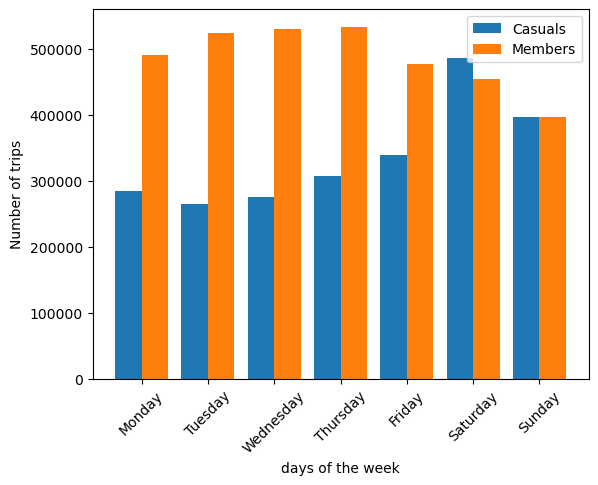

In [24]:
X = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
  
X_axis = np.arange(len(X))
  
plt.bar(X_axis - 0.2, casuals_days_of_week_dist, 0.4, label = 'Casuals')
plt.bar(X_axis + 0.2, members_days_of_week_dist, 0.4, label = 'Members')
#plt.bar(X_axis - 0.2, casuals_days_of_week_dist/np.sum(casuals_days_of_week_dist), 0.4, label = 'Casuals')
#plt.bar(X_axis + 0.2, members_days_of_week_dist/np.sum(members_days_of_week_dist), 0.4, label = 'Members')
plt.xticks(X_axis, X,rotation = 45)
plt.xlabel("days of the week")
plt.ylabel("Number of trips")
#plt.title("Number of tri in each group")
plt.legend()
plt.show()

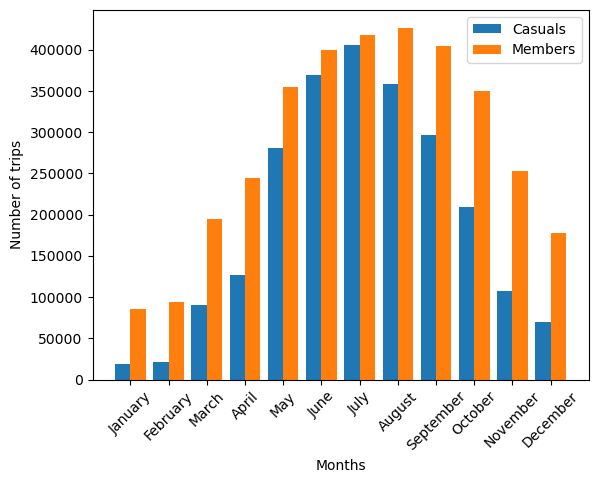

In [25]:
X = ["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"]

  
X_axis = np.arange(len(X))
  
plt.bar(X_axis - 0.2, casuals_month_dist, 0.4, label = 'Casuals')
plt.bar(X_axis + 0.2, members_month_dist, 0.4, label = 'Members')
#plt.bar(X_axis - 0.2, casuals_month_dist/np.sum(casuals_month_dist), 0.4, label = 'Casuals')
#plt.bar(X_axis + 0.2, members_month_dist/np.sum(members_month_dist), 0.4, label = 'Members')

plt.xticks(X_axis, X, rotation=45)
plt.xlabel("Months")
plt.ylabel("Number of trips")
#plt.title("Number of tri in each group")
plt.legend()
plt.show()

non-members strongly prefer warmer months and weekends for the trips.

suggestion: ramp-up marketing of benefit membership to may-august tourists, partner with local events that draw tourists, introduce a weekly suscription model, since visitors likely dont say for multiple months

<AxesSubplot:ylabel='Frequency'>

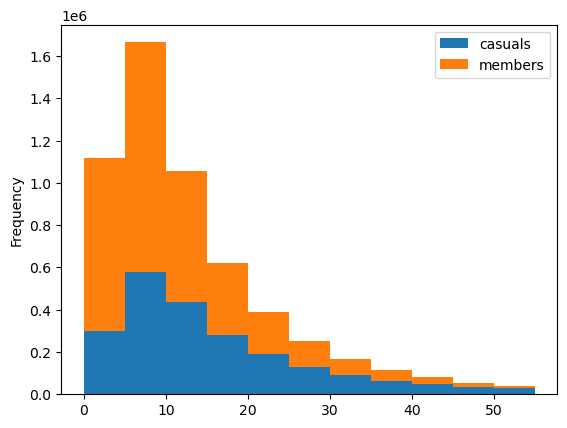

In [81]:
durations = pd.DataFrame({'casuals': casuals_duration_dist, 'members': members_duration_dist})
durations.plot.hist(bins=[0,5,10,15,20,25,30,35,40,45,50,55],stacked=True)


In [29]:
summary_columns=['user_type','number of trips','average trip distance(miles)','average trip duration(minutes)','electric bike proportion']
casuals_summary=['casual users',num_trips_casuals,avg_distance_casuals,avg_ride_length_casuals,electric_casuals_proportion]
members_summary=['members',num_trips_members,avg_distance_members,avg_ride_length_members,electric_members_proportion]
summary=[casuals_summary,members_summary]
summary_df=pd.DataFrame(summary,columns=summary_columns)
summary_df

,user_type,number of trips,average trip distance(miles),average trip duration(minutes),electric bike proportion
0,casual users,2353033,1.358528,0 days 00:29:10.206343472,0.541174
1,members,3402661,1.297527,0 days 00:12:42.663126006,0.488486


no clear difference between members and casual users in terms of trip duration